In [35]:
import cv2
import pickle
import os
os.environ['GLOB_v'] = '0'
os.environ["GLOG_minloglevel"] = "3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import gc
import glob
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
#from torch.cuda import empty_cache
from IPython.display import display, Image, clear_output

size = 20

In [36]:
def get_video_path_list(dir_path):
    dir_list = glob.glob(dir_path)

    video_list = []

    for list in dir_list:
        file_list = []

        file_list.append(str(list).split('/')[-1])
        file_list.append(glob.glob(list + "/*"))
        video_list.append(file_list)

    return video_list

def extract_pose_landmarks(results):
    xyz_list = []

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]

    neck_x = (results.pose_landmarks.landmark[11].x + results.pose_landmarks.landmark[12].x) / 2
    neck_y = (results.pose_landmarks.landmark[11].y + results.pose_landmarks.landmark[12].y) / 2
    neck_z = (results.pose_landmarks.landmark[11].z + results.pose_landmarks.landmark[12].z) / 2

    for idx, lm in enumerate(results.pose_landmarks.landmark):
        if idx in points:
            x = int(lm.x - neck_x)
            y = int(lm.y - neck_y)
            z = int(lm.z - neck_z)

            xyz_list.append(x)
            xyz_list.append(y)
            xyz_list.append(z)

    return xyz_list

def video_xyz_list(xyz_list, xyz_list_list):
    xyz_list_list.append(xyz_list)

    return xyz_list_list

def generate_dataset(path):
    cap = cv2.VideoCapture(path)
    mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    xyz_list_list = []
    if cap.isOpened():
        while True:
            ret, frame = cap.read()
            if ret:
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (640, 640))
                results = mp_pose.process(image)

                if results.pose_landmarks is None: continue

                xyz_list = extract_pose_landmarks(results)

                xyz_list_list.append(xyz_list)
            else:
                break

        cap.release()

    return xyz_list_list

In [26]:
video_list = get_video_path_list("/home/shin/deeplearning-repo-1/dataset/*")
dataset = []

cnt = 0
for classes in video_list:
    class_label = classes[0]
    if class_label == 'standing':
        label = 0
    elif class_label == 'pushup':
        label = 1
    elif class_label == 'stand_knee_raise':
        label = 2
    elif class_label == 'shoulder_press':
        label = 3
        
    for file in classes[1]:
        cnt += 1
        pose_data = generate_dataset(file)

        if cnt % 20 == 0:
            gc.collect()
            #empty_cache()

        for idx in range(0, len(pose_data), size):
            seq_list = pose_data[idx:idx+size]
            if len(seq_list) == size:
                dataset.append({'key':label,'value':seq_list})

        clear_output()

In [27]:
with open('keypoints.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [37]:
with open('keypoints.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [38]:
X, y = [], []

for data in dataset:
    y.append(data['key'])
    X.append(data['value'])

X = np.array(X)
y = np.reshape(y, (len(y), 1))

In [39]:
X.shape, y.shape

((563, 20, 36), (563, 1))

In [40]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout

In [48]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(size, 36)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/shin/venv/project/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 20, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 20, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,868 (2.67 MB)

 Trainable params: 700,868 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
hist = model.fit(X, y, epochs=100, batch_size=10, validation_split=0.1)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4200 - loss: 1.1505 - val_accuracy: 0.0000e+00 - val_loss: 1.2596
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4626 - loss: 1.1051 - val_accuracy: 0.0000e+00 - val_loss: 1.3222
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3983 - loss: 1.1922 - val_accuracy: 1.0000 - val_loss: 1.1999
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4388 - loss: 1.1024 - val_accuracy: 1.0000 - val_loss: 1.2582
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4540 - loss: 1.0756 - val_accuracy: 0.0000e+00 - val_loss: 1.2498
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4699 - loss: 1.1375 - val_accuracy: 0.0000e+00 - val_loss: 1.3410
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4682 - loss: 1.1089 - val_accuracy: 0.0000e+00 - val_loss: 1.3245
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4173 - loss: 1.1460 - v

In [22]:
model.save("faa.keras")

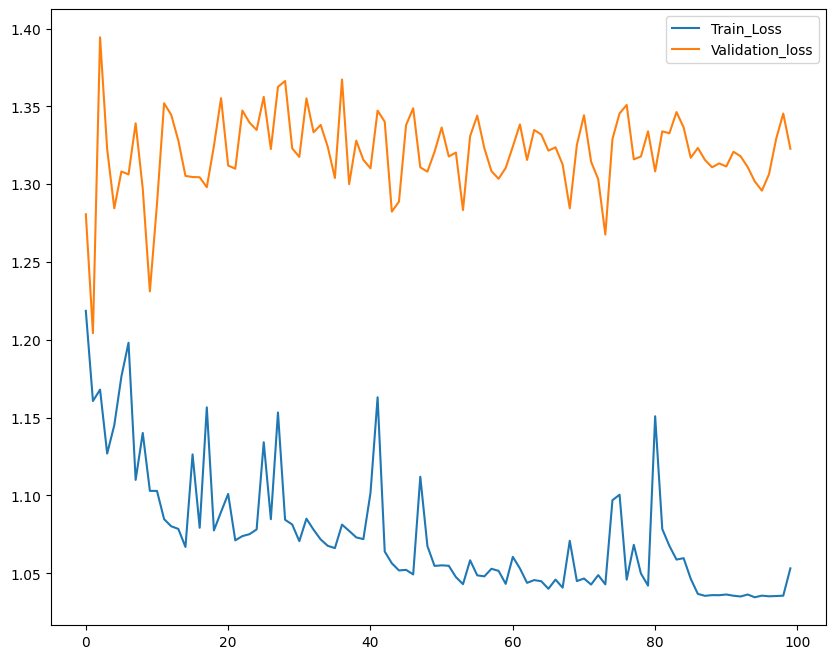

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history['loss'], label='Train_Loss')
plt.plot(hist.history['val_loss'], label='Validation_loss')
plt.legend()
plt.show()

In [46]:
def video_show(frame, width=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width))

In [6]:
model = load_model('faa.keras')

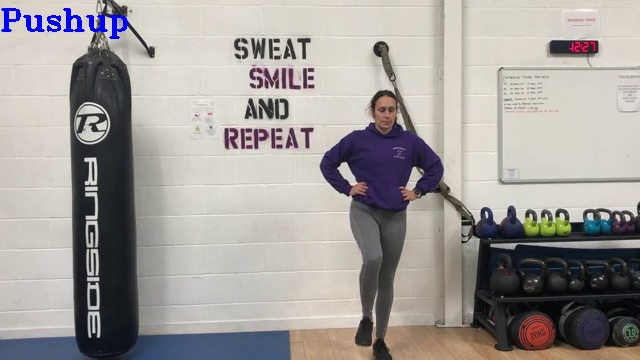

KeyboardInterrupt: 

In [51]:
path = "/home/shin/deeplearning-repo-1/dataset/stand_knee_raise/standing.mp4"
cap = cv2.VideoCapture(path)

mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
sequence = []
if cap.isOpened():
    while True:
        ret, frame = cap.read()
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (640, 640))

            results = mp_pose.process(image)

            if results.pose_landmarks is None: continue
            
            sequence.append(extract_pose_landmarks(results))

            if len(sequence) == 20:
                data = np.array(sequence).reshape(1, 20, 36)

                predict = model.predict(data)
                predict_class = np.argmax(predict, axis=1)

                if predict_class == 0:
                    label = "Standing"
                elif predict_class == 1:
                    label = "Pushup"
                elif predict_class == 2:
                    label = "Staning Knee Raise"
                elif predict_class == 3:
                    label = "Shoulder Press"

                cv2.putText(frame, label, (0, 30), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 0, 0), 2)

                sequence = sequence[1:]

            video_show(frame, 640)
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [23]:
gc.collect()

1668